In [19]:
import requests as rq
import json
pd.options.plotting.backend = "plotly"
import numpy as np

In [18]:
# Get demo API key
def get_demo_key():
    f = open("/home/vikas/Documents/CG_demo_key.json")
    key_dict = json.load(f)
    return key_dict["key"] 

In [9]:
# Get API key
def get_pro_key():
    f = open("/home/vikas/Documents/CG_pro_key.json")
    key_dict = json.load(f)
    return key_dict["key"] 

## Check API status

In [10]:
PUB_URL = "https://api.coingecko.com/api/v3"
PRO_URL = "https://pro-api.coingecko.com/api/v3"

In [11]:
def get_response(endpoint, headers, params, URL):
    url = "".join((URL, endpoint))
    response = rq.get(url, headers = headers, params = params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to fetch data, check status code {response.status_code}")    

In [14]:
use_demo = {
           "accept": "application/json",
           "x-cg-demo-api-key" : get_demo_key() 
}

In [15]:
get_response("/ping", use_demo, "", PUB_URL)

{'gecko_says': '(V3) To the Moon!'}

In [17]:
use_pro = {
         "accept": "application/json",
         "x-cg-pro-api-key" : get_pro_key()          
}

## Fetch list of NFTs

#### Demo API

In [20]:
import pandas as pd

In [21]:
nft_params = {
            "order": "market_cap_usd_desc",
            "per_page": 5,
            "page": 1
}

In [22]:
nft_list_response = get_response("/nfts/list", use_demo, nft_params, PUB_URL)

In [23]:
df_nft = pd.DataFrame(nft_list_response)

In [25]:
df_nft

,id,contract_address,name,asset_platform_id,symbol
0,galxe-oat-v2,0x5d666f215a85b87cb042d59662a7ecd2c8cc44e6,Galaxy OAT,polygon-pos,OAT
1,cryptopunks,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,CryptoPunks,ethereum,PUNK
2,cometh-spaceships,0xbcd4f1ecff4318e7a0c791c7728f3830db506c71,Cometh Spaceships,ethereum,SPACESHIP
3,bored-ape-yacht-club,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,ethereum,BAYC
4,yuliorigingenone,0x735c4a681f1649f5eee8aac871aa1d89ff056217,YuliOriginGenOne,binance-smart-chain,YOG1


In [26]:
df_nft.id[4]

'yuliorigingenone'

In [27]:
def get_nft_current_data(index, df_nft, use_demo = use_demo, PUB_URL = PUB_URL):
    nft_url = f"/nfts/{df_nft.id[index]}"
    nft_current_response = get_response(nft_url, use_demo, nft_params, PUB_URL)
    
    new_data = dict(id = nft_current_response["id"], 
                    name = nft_current_response["name"],
                    symbol = nft_current_response["symbol"],
                    floor_price_usd = nft_current_response["floor_price"]["usd"])
    
    return new_data

In [28]:
def get_nft_floor_prices(order_by, per_page):

    assert per_page <= 250, "Number of entries per page should be less than 250"

    nft_params = {
                 "order": order_by,
                 "per_page": per_page,
                 "page": 1
                 }

    nft_list_response = get_response("/nfts/list", use_demo, nft_params, PUB_URL)
    df_nft = pd.DataFrame(nft_list_response)

    nft_list_all = []

    for i in range(len(df_nft.id)):
        new_data = get_nft_current_data(i, df_nft)
        nft_list_all.append(new_data)

    df_floor_price = pd.DataFrame(nft_list_all)

    return df_floor_price   

In [29]:
df_floor_price = get_nft_floor_prices("market_cap_usd_desc", 10)

In [30]:
df_floor_price

,id,name,symbol,floor_price_usd
0,galxe-oat-v2,Galaxy OAT,OAT,730.44
1,cryptopunks,CryptoPunks,PUNK,140494.00
2,cometh-spaceships,Cometh Spaceships,SPACESHIP,77510.00
3,bored-ape-yacht-club,Bored Ape Yacht Club,BAYC,56188.00
4,yuliorigingenone,YuliOriginGenOne,YOG1,105393.00
5,pudgy-penguins,Pudgy Penguins,PPG,40080.00
6,blendkemon,Blendkemon,B & K,11070698.00
7,the-crop-collective,The Crop Collective,$TCC,909287.00
8,autoglyphs,Autoglyphs,☵,553743.00
9,catgirl-nft,Catgirl NFT,CATGIRLNFT,734.59


#### Pro API

In [62]:
page_params = {
            "per_page": 100,
            "page": 1,
            "order": "h24_volume_usd_desc"    
}

In [63]:
nft_markets = get_response("/nfts/markets", use_pro, page_params, PRO_URL)

In [65]:
nft_markets[10];

In [46]:
def get_nft_markets(num_entries, order_by):
    
    assert num_entries <= 250, "Number of entries per page should be less than 250"
    
    page_params = {
                    "per_page": num_entries,
                    "page": 1,
                    "order": order_by    
                  }
    
    nft_markets = get_response("/nfts/markets", use_pro, page_params, PRO_URL) 
    nft_all = []

    for i in range(len(nft_markets)):
        nft_select = nft_markets[i]
        temp_dict = dict(
                         id = nft_select["id"],
                         asset_platform_id  = nft_select["asset_platform_id"],
                         floor_price_native = nft_select["floor_price"]["native_currency"],
                         floor_price_usd    = nft_select["floor_price"]["usd"],
                         market_cap_usd     = nft_select["market_cap"]["usd"],
                         volume_24h_usd     = nft_select["volume_24h"]["usd"]
                        )
        nft_all.append(temp_dict)
            
    return pd.DataFrame(nft_all)                     


In [60]:
df_nft_markets = get_nft_markets(10, "h24_volume_usd_desc")

In [61]:
df_nft_markets

,id,asset_platform_id,floor_price_native,floor_price_usd,market_cap_usd,volume_24h_usd
0,bored-ape-yacht-club,ethereum,29.3900,57480.00,574686254,1220869
1,bitcoin-frogs,ordinals,0.1416,5194.50,51944983,1043760
2,mutant-ape-yacht-club,ethereum,5.5900,10921.59,212796258,949123
3,degods,ethereum,3.1200,6099.32,54546199,644587
4,mad-lads,solana,100.5200,5909.44,58893484,594917
5,the-captainz,ethereum,4.2800,8374.34,83735026,557373
6,nouns,ethereum,28.6400,55904.00,51319846,413234
7,azuki,ethereum,5.8000,11339.57,113395718,384756
8,pudgy-penguins,ethereum,5.7400,11247.36,99966496,344371
9,cryptopunks,ethereum,57.3000,111848.00,1117810422,336501


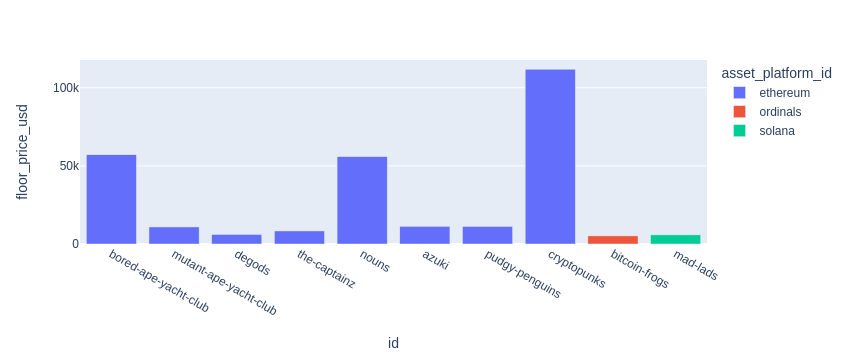

In [59]:
import plotly.express as px

fig2 = px.bar(df_nft_markets, x = "id", y = "floor_price_usd", color = "asset_platform_id")
fig2.show()

In [104]:
def get_nft_hist(nft_id, num_days):
    hist_params = {"days": num_days}
    hist_url = f"/nfts/{nft_id}/market_chart"
    
    nft_hist = get_response(hist_url, use_pro, hist_params, PRO_URL)
    all_time, all_floor_price_usd = [], []    

    floor_price_usd = nft_hist["floor_price_usd"]

    for i in range(len(floor_price_usd)):
        time = floor_price_usd[i][0]
        all_time.append(time)
        
        price = floor_price_usd[i][1]
        all_floor_price_usd.append(price)

    df_hist = pd.DataFrame(list(zip(all_time, all_floor_price_usd)),
                           columns =['Time', 'Price_usd'])

    df_hist["Time"] = pd.to_datetime(df_hist["Time"], unit = "ms")
    #df_hist.set_index("Time", inplace = True)

    return df_hist    
    

In [112]:
df_hist = get_nft_hist(df_nft_markets.id[7], 365)

In [113]:
df_hist

,Time,Price_usd
0,2022-11-24 00:05:09,11517.021657
1,2022-11-25 00:05:10,11179.088841
2,2022-11-26 00:05:05,11217.841667
3,2022-11-27 00:05:02,12051.988169
4,2022-11-28 00:05:03,12522.868492
...,...,...
360,2023-11-19 00:05:52,11338.806945
361,2023-11-20 00:05:14,11631.327683
362,2023-11-21 00:05:48,11469.485746
363,2023-11-22 00:05:38,10558.001312


In [114]:
df_hist['SMA'] = df_hist['Price_usd'].rolling(5).mean() 

In [115]:
df_hist

,Time,Price_usd,SMA
0,2022-11-24 00:05:09,11517.021657,NaN
1,2022-11-25 00:05:10,11179.088841,NaN
2,2022-11-26 00:05:05,11217.841667,NaN
3,2022-11-27 00:05:02,12051.988169,NaN
4,2022-11-28 00:05:03,12522.868492,11697.761765
...,...,...,...
360,2023-11-19 00:05:52,11338.806945,11735.342993
361,2023-11-20 00:05:14,11631.327683,11705.276396
362,2023-11-21 00:05:48,11469.485746,11506.803498
363,2023-11-22 00:05:38,10558.001312,11290.665978


## Plot data

In [44]:
fig1 = df_hist.plot(title = f"Historical floor price for {df_nft_markets.id[5]}",
                    template = "seaborn",
                    labels = dict(index = "Time", value = "Price [USD]"))

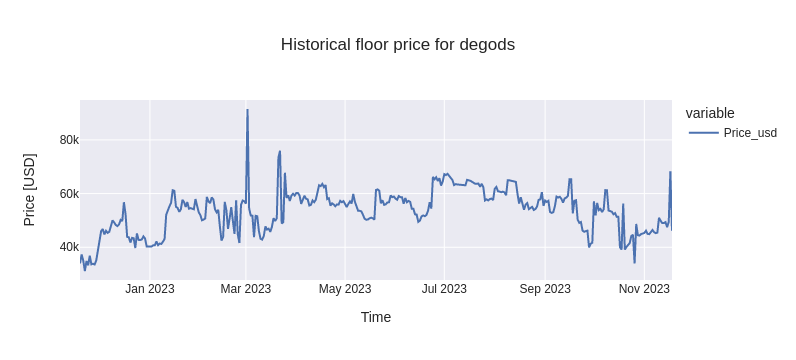

In [45]:
fig1.show()

In [32]:
def plot_nft_hist(nft_id, num_days):
    df_hist = get_nft_hist(nft_id, num_days)
    fig = df_hist.plot(title = f"Historical floor price for {nft_id}",
                       template = "seaborn",
                       labels = dict(index = "Time", value = "Price [USD]"))
    fig = go.Figure(fig)
    return fig   
    

## Dash app

In [34]:
import dash
from dash import html
from dash import dcc
import plotly.graph_objects as go
import plotly.express as px
from dash.dependencies import Input, Output  

#### Layout with dropdown

In [35]:
app = dash.Dash()

app.layout = html.Div(id = 'parent', children = [
    html.H1(id = 'H1', children = 'NFT Floor Price Tracker', 
                       style = {'textAlign':'center', 'marginTop':40, 'marginBottom':40}),
    
    dcc.Dropdown( id = 'NFT ID',
    options = [
    {'label': 'bitcoin-frogs', 'value':'bitcoin-frogs' },
    {'label': 'mutant-ape-yacht-club', 'value':'mutant-ape-yacht-club'},
    {'label': 'mad-lads', 'value':'mad-lads'},
    ],
    value = 'pudgy-penguins'),
    
    dcc.Graph(id = 'line_plot')
   ])

#### Callback

In [36]:
@app.callback(Output(component_id = 'line_plot', component_property = 'figure'),
              [Input(component_id = 'NFT ID', component_property= 'value')])
def graph_update(dropdown_value):
    return plot_nft_hist(dropdown_value, 180)

In [37]:
if __name__ == '__main__': 
    app.run_server()

In [68]:
colors = ['red'] * 5

In [69]:
colors

['red', 'red', 'red', 'red', 'red']

In [70]:
colors[1]

'red'